<a href="https://colab.research.google.com/github/sljm12/machine_learning_notebooks/blob/master/LSTM_Accelerometer/LSTM_Accerlormeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration into using LSTM for classifying accelerometer data

We will be looking at classifying common things such as walking, jumping, standing still using LSTMs.

The data is collected using the phone's accelerometer. I used a simple app developed in App Inventor to collect the data into a csv file for processing.

You can find the app here https://gallery.appinventor.mit.edu/?galleryid=61f1792c-37b3-44ed-b87a-f6020728d85d

## File naming convention
__label__-__position__-__extra__.csv

### label
* running
* still
* walking
* jumping

### position
* f - top of handphone facing front
* u - top of handphone facing skywards
* l - screen of handphone facing left
* r - screen of handphone facing right


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers  import Layer, LSTM, Dense
from tensorflow.keras.models import Sequential

import pandas as pd
from numpy import array
from sklearn.model_selection import train_test_split
import numpy as np

import glob,os
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
nfeatures = 3 # the features are X,Y,Z of the accerlormeter
window_size = 3 # the number of records of X,Y,Z that we will count as one time sequence, hyperparameter

## Test Data loading functions

In [ ]:
def plot_chart(ax, title, df):
  ax.set_title(title, fontsize=4)
  ax.set_ylabel("Accerlerometer", fontsize=4)
  #ax.set_xlabel(fontsize=4)
  ax.tick_params(axis='both', which='major', labelsize=4)
  ax.tick_params(axis='both', which='minor', labelsize=4)
  ax.plot(df.index, df["X"], label = "X")
  ax.plot(df.index, df["Y"], label = "Y")
  ax.plot(df.index, df["Z"], label = "Z")
 
  

In [ ]:
def plot_files(list_files):
  cat = {}
  for i in list_files:
    base=os.path.basename(i)
    category = base.split("-")[0]
    if category not in cat:
      cat[category] = []
    cat[category].append(i)
  print(cat.keys())
  max_x=0

  #Find out how many subplots we need the Y and the X columns
  for i in cat:
    if max_x < len(cat[i]):
      max_x=len(cat[i])
  print(len(cat.keys()),max_x)
  fig,ax = plt.subplots(len(cat.keys()),max_x,dpi=200)
  plt.xticks(fontsize=4)
  y=0

  for i in cat:
    for j in range(len(cat[i])):
      df=pd.read_csv(cat[i][j], delimiter=",",header=None, names=["X","Y","Z"])
      basename = os.path.basename(cat[i][j])
      if len(cat.keys()) == 1:
        plot_chart(ax[j],basename, df)
      else:
        plot_chart(ax[y,j],basename, df)
    y=y+1

Simple plot of the various CSV files. Wecan tell that there are differences in the plots for the different activities.

dict_keys(['still', 'walking', 'jumping', 'run'])
4 5


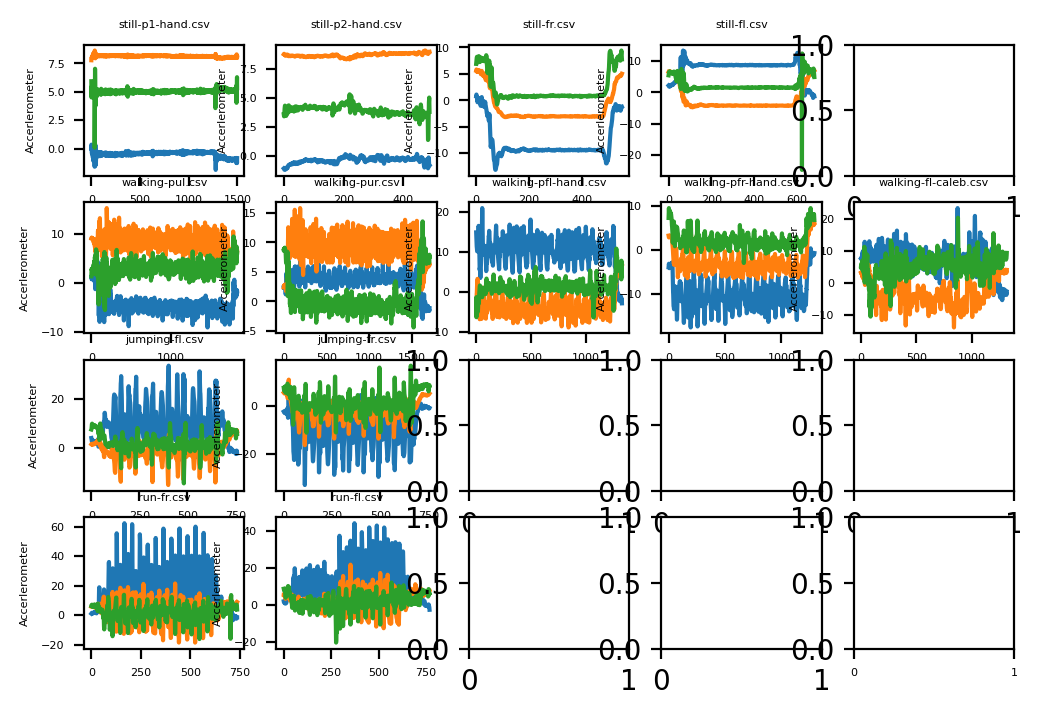

In [ ]:
plot_files(glob.glob("/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/*.csv"))

In [ ]:
#Extract the data in the dataframe to an array
def convert_to_array(df, loc):
  row = df.loc[loc]
  return [row["X"],row["Y"], row["Z"]]

In [ ]:
#Performs the sliding window extraction of data from the data frame.
#Generates arrays of data with a size of window_size and sliding window of size 1
def convert_df_to_array(df, window_size):
  results = []
  start_record = window_size - 1
  #print(start_record, len(df))

  for i in range(start_record, len(df)):
    temp_arr = []
    for r in range(start_record,-1,-1):
      a = convert_to_array(df,i-r)
      temp_arr.append(a)
    results.append(temp_arr)
  return results

### Looking at Test Data

The test data has a mixture of walking, standing still and jumping in the same file

dict_keys(['test'])
1 4


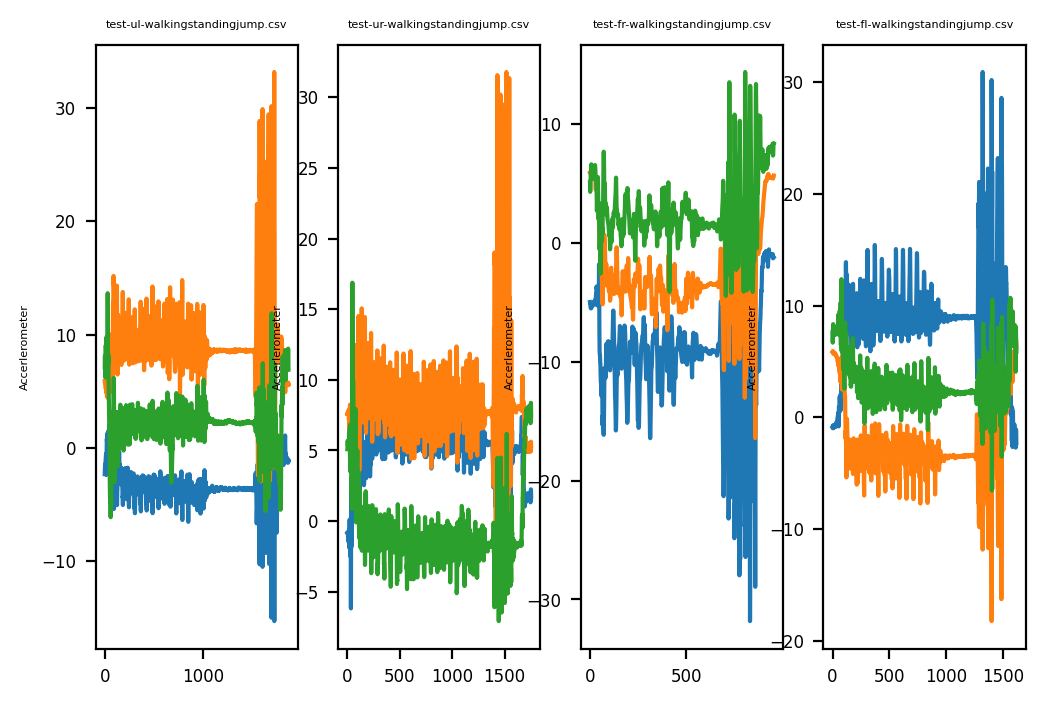

In [ ]:
plot_files(glob.glob("/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/Test/*.csv"))

## Loading Data

In [ ]:
content_dir="/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/*.csv"

In [ ]:
files = glob.glob(content_dir)

In [ ]:
files

['/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-p1-hand.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-p2-hand.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pul.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pur.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pfl-hand.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pfr-hand.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/jumping-fl.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/jumping-fr.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-fr.csv',
 '/content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-fl.csv',
 '/content/drive/MyDrive/Colab Not

In [ ]:
categories_data={}

In [ ]:
#Read all the files and segregate them into categories based on the filename, perform a sliding window extraction on the df and put them into a dict 
for f in files:
  basename = os.path.basename(f)
  #print(basename)
  category = basename.split("-")[0]

  if category not in categories_data:
    categories_data[category]=[]
    
  df = pd.read_csv(f, delimiter=",",header=None, names=["X","Y","Z"])
  #print(category,basename,len(df))
  results = convert_df_to_array(df,window_size)
  print(category,f,len(results))
  categories_data[category] = categories_data[category] + results
  

still-p1-hand.csv
still still-p1-hand.csv 1498
still /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-p1-hand.csv 1496
still-p2-hand.csv
still still-p2-hand.csv 488
still /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/still-p2-hand.csv 486
walking-pul.csv
walking walking-pul.csv 1839
walking /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pul.csv 1837
walking-pur.csv
walking walking-pur.csv 1712
walking /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pur.csv 1710
walking-pfl-hand.csv
walking walking-pfl-hand.csv 1325
walking /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pfl-hand.csv 1323
walking-pfr-hand.csv
walking walking-pfr-hand.csv 1293
walking /content/drive/MyDrive/Colab Notebooks/Walking, Standing, Running detection/walking-pfr-hand.csv 1291
jumping-fl.csv
jumping jumping-fl.csv 759
jumping /content/drive/MyD

In [ ]:
categories_data.keys()

dict_keys(['still', 'walking', 'jumping', 'run'])

In [ ]:
num_categories = len(categories_data.keys())

In [ ]:
len(categories_data["jumping"])

1510

In [ ]:
X_all = []
Y_all = None
category_num=0
for i in categories_data.keys():
  
  data = categories_data[i]
  print(i, len(data), category_num)
  X_all =X_all+data

  #Fill Y with the same category number
  Y = np.full((len(data)), category_num)

  if Y_all is None:
    Y_all=Y
  else:
    Y_all = np.concatenate([Y_all, Y])
  category_num=category_num+1

still 3213 0
walking 6161 1
jumping 1510 2
run 1503 3


Sanity Check on the data, make sure X_all and Y_all has the same number of rows

In [ ]:
print(array(X_all).shape)
print(Y_all.shape)

(12387, 3, 3)
(12387,)


Change Y to categorical since we will be doing prediction on this

In [ ]:
Y = tf.keras.utils.to_categorical(
    Y_all, num_classes=len(categories_data.keys()), dtype='float32'
)

In [ ]:
Y[0]

array([1., 0., 0., 0.], dtype=float32)

In [ ]:
Y_all.shape

(12387,)

In [ ]:
Y.shape

(12387, 4)

In [ ]:
X = array(X_all)

In [ ]:
X.shape

(12387, 3, 3)

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, stratify=Y,test_size=0.2)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(9909, 3, 3)
(9909, 4)


In [ ]:
print(X_test.shape)
print(Y_test.shape)

(2478, 3, 3)
(2478, 4)


In [ ]:
number_val=X_test.shape[0]

In [ ]:
X_train, X_val, Y_train, Y_val=train_test_split(X_train,Y_train, stratify=Y_train,test_size=number_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7431, 3, 3)
(2478, 3, 3)
(2478, 3, 3)


## Model

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, nfeatures)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(num_categories,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
233/233 [==============================] - 18s 56ms/step - loss: 0.6696 - accuracy: 0.7177 - val_loss: 0.4820 - val_accuracy: 0.8015
Epoch 2/10
233/233 [==============================] - 12s 50ms/step - loss: 0.4487 - accuracy: 0.8268 - val_loss: 0.3945 - val_accuracy: 0.8450
Epoch 3/10
233/233 [==============================] - 13s 54ms/step - loss: 0.3718 - accuracy: 0.8552 - val_loss: 0.3639 - val_accuracy: 0.8600
Epoch 4/10
233/233 [==============================] - 11s 48ms/step - loss: 0.3279 - accuracy: 0.8703 - val_loss: 0.3229 - val_accuracy: 0.8737
Epoch 5/10
233/233 [==============================] - 7s 30ms/step - loss: 0.3092 - accuracy: 0.8810 - val_loss: 0.3228 - val_accuracy: 0.8749
Epoch 6/10
233/233 [==============================] - 6s 24ms/step - loss: 0.2859 - accuracy: 0.8876 - val_loss: 0.2860 - val_accuracy: 0.8854
Epoch 7/10
233/233 [==============================] - 5s 23ms/step - loss: 0.2790 - accuracy: 0.8890 - val_loss: 0.2886 - val_accuracy: 0.

In [ ]:
score=model.evaluate(X_test, Y_test,verbose=1)

NameError: ignored

In [ ]:
print("model accuracy:",score[1])

model accuracy: 0.903954803943634


In [ ]:
#Stil
p=[[[-0.41563,8.08524,5.5102],
[-0.49123,8.11504,5.37795],
[-0.50332,8.09788,5.09719]]]

In [ ]:
#Still
p=[[[-0.38491,8.14143,5.06747],
[-0.54609,8.18908,5.06608],
[-0.62868,8.20477,5.04401]]]

In [ ]:
#Walking
p=[[[-3.09947,2.87074,9.53638],
[-3.30868,2.91869,8.81791],
[-3.55979,2.95509,7.95126]]]

In [ ]:
results=model.predict(p)

In [ ]:
results

array([[0.2000205 , 0.5428243 , 0.25606576, 0.00108939]], dtype=float32)

In [ ]:
results[0].argmax()

1